In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import json 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from preprocessor import get_train_environment

# Tune n_estimators & max_depth

In [2]:
# Define parameter grid
n_estimators = [100,500,1000,5000,10000,15000,20000]
max_depth = list(range(1, 5, 1))
param_grid = [(n, d) for n in n_estimators for d in max_depth]

# Initialize variables to track the best parameters
best_params = None
best_score = float('inf')
model_performance = []

# Iterate over all combinations of parameters
for n, d in param_grid:
    mse_scores = []
    print(n,d)
    
    # Iterate over folds
    envGen = get_train_environment(n_splits=5)
    stats, X, X_holdout, y, y_holdout = next(envGen)
    
    for fold, stats, X_train, X_test, y_train, y_test in envGen:
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Skipping empty fold: {fold}")
            continue

        # Create and fit the model
        model = XGBRegressor(n_estimators=n, max_depth=d)
        model.fit(X_train, y_train)

        # Predict and evaluate
        predictions = model.predict(X_test)

        # Check if predictions are valid
        if not np.any(np.isnan(predictions)):
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            #print("Mean Squared Error: ", mse)
            #print("R-Squared: ", r2)
            mse_scores.append(mse)
            performance = {
                'n_estimators': n,
                'max_depth': d,
                'Fold':fold,
                'MSE': mse,
                'R2': r2
            }
            model_performance.append(performance)
        else:
            print(f"Invalid predictions in fold: {fold}")       

    # Average MSE across folds for current parameter combination
    avg_mse = np.mean(mse_scores)
    # Update best parameters if current combination is better
    if avg_mse < best_score:
        best_score = avg_mse
        best_params = (n, d)


100 1
Found cached folds, using those
100 2
Found cached folds, using those
100 3
Found cached folds, using those
100 4
Found cached folds, using those
500 1
Found cached folds, using those
500 2
Found cached folds, using those
500 3
Found cached folds, using those
500 4
Found cached folds, using those
1000 1
Found cached folds, using those
1000 2
Found cached folds, using those
1000 3
Found cached folds, using those
1000 4
Found cached folds, using those
5000 1
Found cached folds, using those
5000 2
Found cached folds, using those
5000 3
Found cached folds, using those
5000 4
Found cached folds, using those
10000 1
Found cached folds, using those
10000 2
Found cached folds, using those
10000 3
Found cached folds, using those
10000 4
Found cached folds, using those
15000 1
Found cached folds, using those
15000 2
Found cached folds, using those
15000 3
Found cached folds, using those
15000 4
Found cached folds, using those
20000 1
Found cached folds, using those
20000 2
Found cached fol

In [3]:
with open('tuning.txt', 'w') as convert_file: 
     convert_file.write(json.dumps(model_performance))

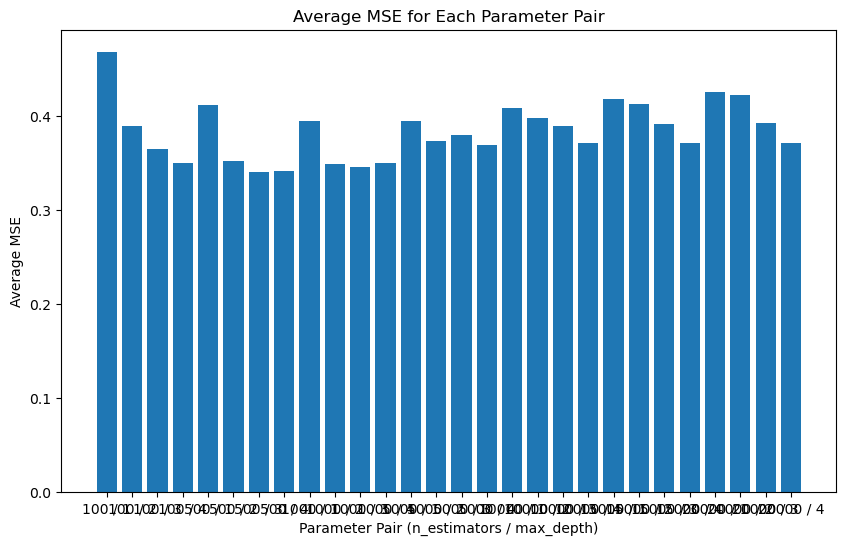

In [4]:
# Aggregate MSE values for each (n_estimators, max_depth) pair
mse_aggregate = {}
r2_aggregate = {}

for entry in model_performance:
    key = (entry['n_estimators'], entry['max_depth'])
    if key not in mse_aggregate:
        mse_aggregate[key] = []
        r2_aggregate[key] = []
    mse_aggregate[key].append(entry['MSE'])
    r2_aggregate[key].append(entry['R2'])

# Calculate average MSE & R2 for each pair
average_mse = {k: sum(v)/len(v) for k, v in mse_aggregate.items()}
average_r2 = {k: sum(v)/len(v) for k, v in r2_aggregate.items()}

# Prepare data for plotting
n_estimators = [k[0] for k in average_mse.keys()]
max_depth = [k[1] for k in average_mse.keys()]
avg_mse = list(average_mse.values())
avg_r2 = list(average_r2.values())
figsize=(10, 15)
plt.bar(range(len(avg_mse)), avg_mse, tick_label=[f"{n} / {d}" for n, d in zip(n_estimators, max_depth)])
plt.xlabel('Parameter Pair (n_estimators / max_depth)')
plt.ylabel('Average MSE')
plt.title('Average MSE for Each Parameter Pair')
plt.savefig('Average MSE for Each Parameter Pair.png')
plt.show()

In [22]:
import pprint


sorted_data = sorted(model_performance, key=lambda x: (x["MSE"], -x["R2"]))
pprint.PrettyPrinter(width=20).pprint(sorted_data)

[{'Fold': 2,
  'MSE': 0.313319278841114,
  'R2': 0.7746108226272685,
  'max_depth': 3,
  'n_estimators': 500},
 {'Fold': 2,
  'MSE': 0.32194171371399205,
  'R2': 0.7684081928046287,
  'max_depth': 3,
  'n_estimators': 1000},
 {'Fold': 3,
  'MSE': 0.32873675692940824,
  'R2': 0.7498820689114087,
  'max_depth': 4,
  'n_estimators': 500},
 {'Fold': 2,
  'MSE': 0.32983949802278095,
  'R2': 0.7627268471976515,
  'max_depth': 4,
  'n_estimators': 500},
 {'Fold': 3,
  'MSE': 0.3319920004462892,
  'R2': 0.7474053310460211,
  'max_depth': 4,
  'n_estimators': 1000},
 {'Fold': 2,
  'MSE': 0.33207921571198745,
  'R2': 0.7611156851606886,
  'max_depth': 2,
  'n_estimators': 1000},
 {'Fold': 3,
  'MSE': 0.33351903692651824,
  'R2': 0.7462434919845811,
  'max_depth': 2,
  'n_estimators': 1000},
 {'Fold': 2,
  'MSE': 0.3352477515755405,
  'R2': 0.7588363690126249,
  'max_depth': 2,
  'n_estimators': 500},
 {'Fold': 2,
  'MSE': 0.33620952995206616,
  'R2': 0.7581445046693205,
  'max_depth': 4,
  'n_es

In [20]:
sorted(average_mse.items(), key=lambda x:x[1])

[((500, 3), 0.3406472686487044),
 ((500, 4), 0.3412431751193649),
 ((1000, 3), 0.34546795470711134),
 ((1000, 2), 0.3485376732890987),
 ((1000, 4), 0.35002669617297466),
 ((100, 4), 0.35011313013765977),
 ((500, 2), 0.35241417932379193),
 ((100, 3), 0.36454391667779),
 ((5000, 4), 0.3696239025003075),
 ((10000, 4), 0.37117129202529364),
 ((15000, 4), 0.37117129202529364),
 ((20000, 4), 0.37117129202529364),
 ((5000, 2), 0.37355695225424934),
 ((5000, 3), 0.38008604118221917),
 ((10000, 3), 0.3893022052369742),
 ((100, 2), 0.38980748648455105),
 ((15000, 3), 0.39172470963723954),
 ((20000, 3), 0.3924300906488665),
 ((5000, 1), 0.3949826051699407),
 ((1000, 1), 0.3950746981473611),
 ((10000, 2), 0.3982091516383922),
 ((10000, 1), 0.4086779534895374),
 ((500, 1), 0.4114728389638481),
 ((15000, 2), 0.4131824415577207),
 ((15000, 1), 0.41805049068330885),
 ((20000, 2), 0.4226377371314312),
 ((20000, 1), 0.42524417730788694),
 ((100, 1), 0.4688390280576994)]

In [23]:
sorted(average_r2.items(), key=lambda x:x[1])

[((100, 1), 0.6566264661114325),
 ((20000, 1), 0.6886061183410106),
 ((20000, 2), 0.6906478476770668),
 ((15000, 1), 0.6938665321057677),
 ((15000, 2), 0.6975640797734843),
 ((500, 1), 0.6986213553641082),
 ((10000, 1), 0.7007305415747164),
 ((10000, 2), 0.7085082086018402),
 ((1000, 1), 0.7106217537456361),
 ((5000, 1), 0.7107570701853508),
 ((20000, 3), 0.7126067998265182),
 ((15000, 3), 0.7131252970715812),
 ((100, 2), 0.7145094109953088),
 ((10000, 3), 0.7149038121406438),
 ((5000, 3), 0.7216293638023832),
 ((5000, 2), 0.7264763258551554),
 ((10000, 4), 0.7282131826968935),
 ((15000, 4), 0.7282131826968935),
 ((20000, 4), 0.7282131826968935),
 ((5000, 4), 0.7293481941352292),
 ((100, 3), 0.7329416609396319),
 ((500, 2), 0.7418850727996825),
 ((100, 4), 0.7435608276650127),
 ((1000, 4), 0.7436822227478898),
 ((1000, 2), 0.7446994778208303),
 ((1000, 3), 0.7468929987310446),
 ((500, 4), 0.7500662463081531),
 ((500, 3), 0.7504079532358195)]

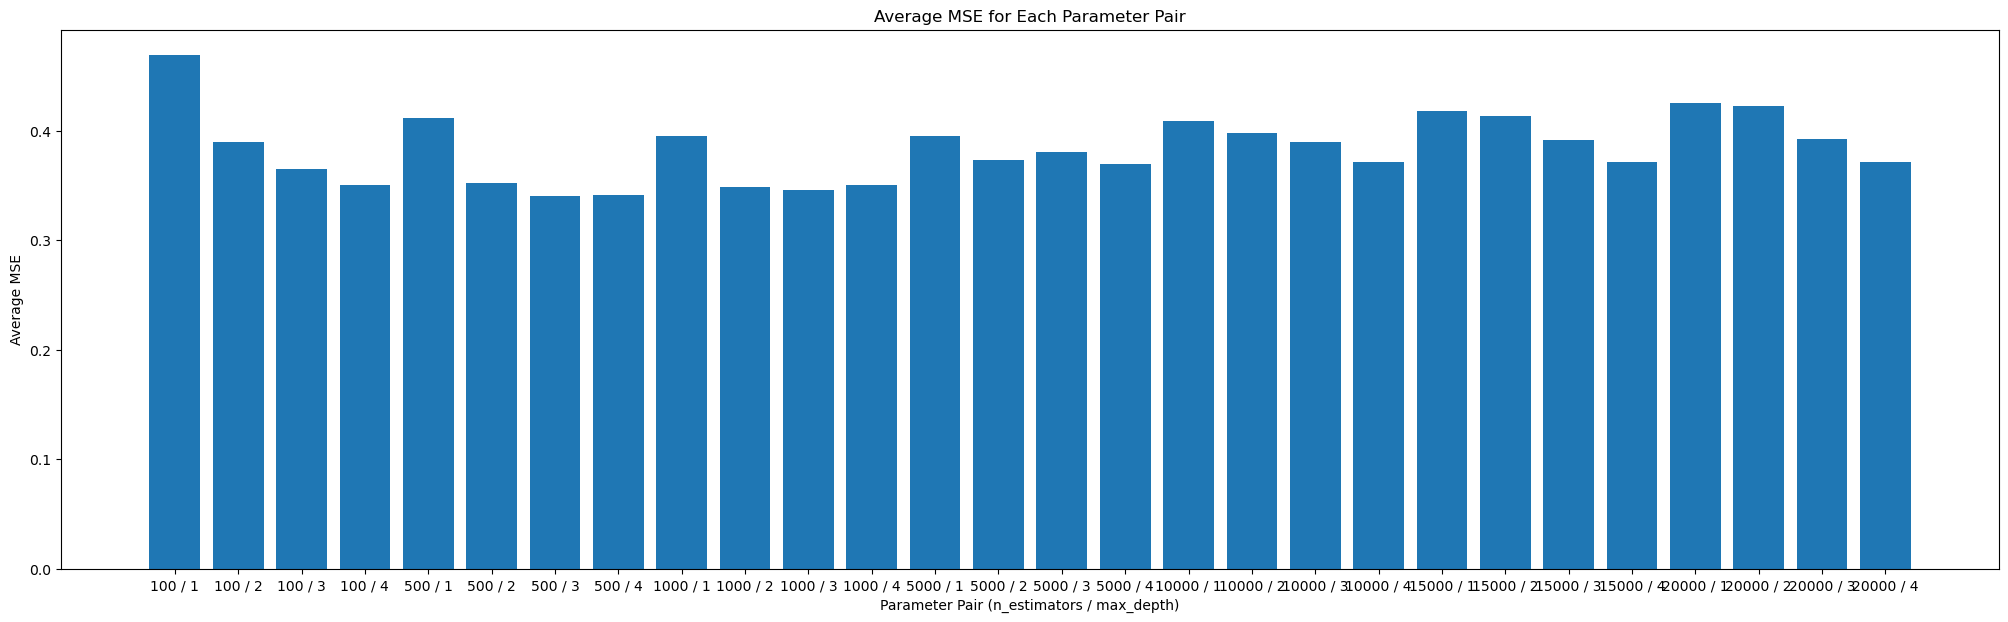

In [14]:
plt.figure(figsize=(25,7))
plt.bar(range(len(avg_mse)), avg_mse, tick_label=[f"{n} / {d}" for n, d in zip(n_estimators, max_depth)])
plt.xlabel('Parameter Pair (n_estimators / max_depth)')
plt.ylabel('Average MSE')
plt.title('Average MSE for Each Parameter Pair')
plt.savefig('Average MSE for Each Parameter Pair.png')
plt.show()

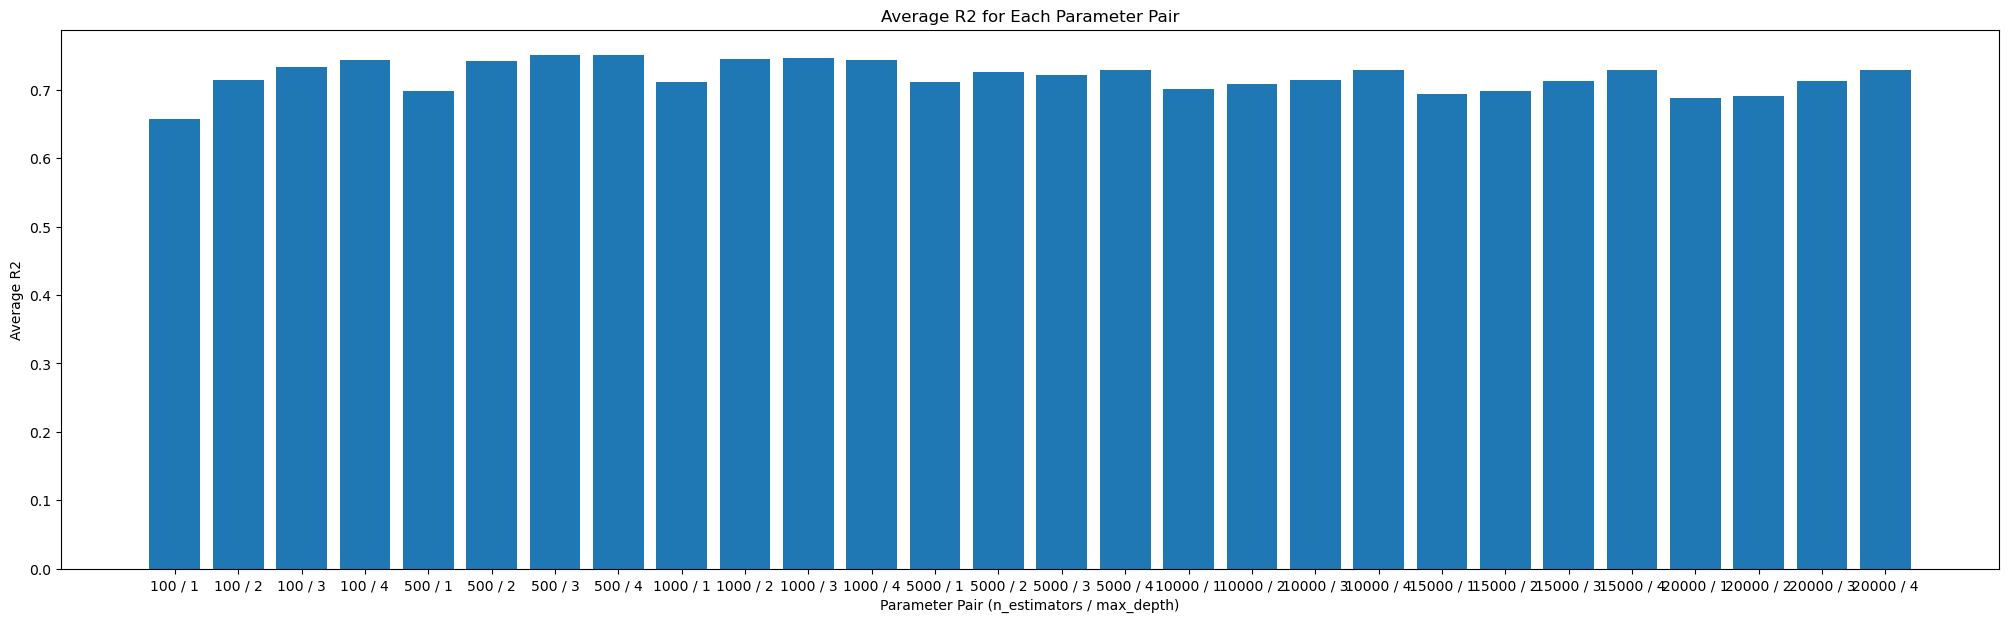

In [24]:
plt.figure(figsize=(25,7))
plt.bar(range(len(avg_r2)), avg_r2, tick_label=[f"{n} / {d}" for n, d in zip(n_estimators, max_depth)])
plt.xlabel('Parameter Pair (n_estimators / max_depth)')
plt.ylabel('Average R2')
plt.title('Average R2 for Each Parameter Pair')
plt.savefig('Average R2 for Each Parameter Pair.png')
plt.show()

In [6]:
print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with MSE: {best_score}")

Best parameters: n_estimators=500, max_depth=3 with MSE: 0.3406472686487044


# Find important feature

In [ ]:

results = []
envGen = get_train_environment(n_splits=15)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

# Cross validation folds
for fold, stats, X_train, X_test, y_train, y_test in envGen:
    print(f"Fold: {fold}")
    model = XGBRegressor(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train, y_train)

    print(model.feature_importances_)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)

    r2 = r2_score(y_test, predictions)
    print("Mean Squared Error: ", mse, "R-Squared: ", r2)

    thresholds = np.sort(model.feature_importances_)[::-1]
    # Fit model using each importance as a threshold
    for thresh in thresholds:
        if thresh > 0.001:
            # Select features using threshold
            selection = SelectFromModel(model, threshold=thresh, prefit=True)
            select_X_train = selection.transform(X_train)

            # Get names of selected features
            #selected_features = X_train_fold.columns[selection.get_support()]

            # Train model
            selection_model = XGBRegressor(n_estimators=best_params[0], max_depth=best_params[1])
            selection_model.fit(select_X_train, y_train)

            # Eval model
            select_X_test = selection.transform(X_test)
            predictions = selection_model.predict(select_X_test)
            mse_select = mean_squared_error(y_test, predictions)
            r2_select = r2_score(y_test, predictions)
            adjusted_r2_select = 1 - (((1 - r2_select) * (len(y_train) - 1)) / (len(y_train) - select_X_train.shape[1] - 1))

            # Save results to dictionary
            results_dict = {
                'Fold':fold,
                'Threshold': thresh,
                #'Selected Features': list(selected_features),
                'Number of Features': select_X_train.shape[1],
                'MSE': mse_select,
                'R2': r2_select,
                'Adjusted R2': adjusted_r2_select
            }
            results.append(results_dict)
            print("Thresh=%.7f, n=%d, Mean Squared Error: %.4f, R-Squared: %.4f, Adj-R-Squared: %.4f" % (thresh, select_X_train.shape[1], mse_select, r2_select, adjusted_r2_select))
        else:
            break

No cached folds found, generating new folds.
Fold: 0
[0.00091899 0.00248584 0.00073835 ... 0.00467962 0.00131084 0.00660688]
Mean Squared Error:  0.367884302380772 R-Squared:  0.7191959102736427
Thresh=0.1927920, n=1, Mean Squared Error: 0.9656, R-Squared: 0.2630, Adj-R-Squared: 0.2629
Thresh=0.1250362, n=2, Mean Squared Error: 0.7696, R-Squared: 0.4125, Adj-R-Squared: 0.4124
Thresh=0.0259328, n=3, Mean Squared Error: 0.7323, R-Squared: 0.4411, Adj-R-Squared: 0.4409
Thresh=0.0124978, n=4, Mean Squared Error: 0.6907, R-Squared: 0.4728, Adj-R-Squared: 0.4726
Thresh=0.0124501, n=5, Mean Squared Error: 0.6633, R-Squared: 0.4937, Adj-R-Squared: 0.4934
Thresh=0.0112186, n=6, Mean Squared Error: 0.6323, R-Squared: 0.5173, Adj-R-Squared: 0.5170
Thresh=0.0109981, n=7, Mean Squared Error: 0.6213, R-Squared: 0.5258, Adj-R-Squared: 0.5254
Thresh=0.0107554, n=8, Mean Squared Error: 0.6195, R-Squared: 0.5271, Adj-R-Squared: 0.5267
Thresh=0.0103002, n=9, Mean Squared Error: 0.5834, R-Squared: 0.5547,

In [ ]:
# Preparing data for plotting
data_by_fold = {}
for entry in results:
    fold = entry['Fold']
    if fold not in data_by_fold:
        data_by_fold[fold] = {'Number of Features': [], 'MSE': [], 'R2': [], 'Adjusted R2': []}
    data_by_fold[fold]['Number of Features'].append(entry['Number of Features'])
    data_by_fold[fold]['MSE'].append(entry['MSE'])
    data_by_fold[fold]['R2'].append(entry['R2'])
    data_by_fold[fold]['Adjusted R2'].append(entry['Adjusted R2'])

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plotting MSE
for fold, data in data_by_fold.items():
    axes[0].plot(data['Number of Features'], data['MSE'], label=f'Fold {fold}')
axes[0].set_title('MSE vs. Number of Features')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('MSE')
axes[0].legend()

# Plotting R2
for fold, data in data_by_fold.items():
    axes[1].plot(data['Number of Features'], data['R2'], label=f'Fold {fold}')
axes[1].set_title('R2 vs. Number of Features')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('R2')
axes[1].legend()

# Plotting Adjusted R2
for fold, data in data_by_fold.items():
    axes[2].plot(data['Number of Features'], data['Adjusted R2'], label=f'Fold {fold}')
axes[2].set_title('Adjusted R2 vs. Number of Features')
axes[2].set_xlabel('Number of Features')
axes[2].set_ylabel('Adjusted R2')
axes[2].legend()

plt.tight_layout()
plt.savefig('XGBoost Feature importance.png')
plt.show()